In [1]:
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt
import scienceplots

In [2]:
qml.drawer.use_style(style='sketch')

## Approximate time-evolution unitary

In this notebook, we will show how to implement an approximate time-evolution unitary operator using the Trotter-Suzuki decomposition. This is a common technique in quantum computing to simulate the time-evolution of a quantum system.

The unitary operator that we want to approximate is given by

$$
U = e^{-iHt},
$$

where $H$ is the Hamiltonian of the system and $t$ is the time.

For quantum circuit, the Hamiltonian usually is composed of a sum of other Hamiltonians:

$$
H = \sum_{i=1}^{n} H_i.
$$

The Trotter-Suzuki decomposition formula is given by

$$
e^{A + B} = \lim_{n \to \infty} \left( e^{A/n} e^{B/n} \right)^n.
$$

It allows us to approximate the time-evolution operator $U$ as

$$
U(H, t, n) = \prod_{j=1}^{n} \prod_k e^{-iH_k t / n}, \quad H = \sum_{k=1}^{n} H_k. 
$$

where $U$ approches $e^{-iHt}$ as $n$ increases.

In [3]:
H = qml.Hamiltonian(
    [1, 1, 0.5],
    [qml.PauliX(0), qml.PauliZ(1), qml.PauliX(0) @ qml.PauliX(1)]
)

print(H)

1 * X(0) + 1 * Z(1) + 0.5 * (X(0) @ X(1))


In [4]:
dev = qml.device("default.qubit", wires=2)

t = 1
n = 2

@qml.qnode(dev)
def circuit(t, n):
    qml.ApproxTimeEvolution(H, t, n)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

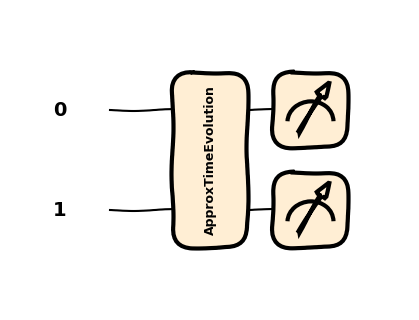

In [5]:
qml.draw_mpl(circuit)(t, n)
plt.show()

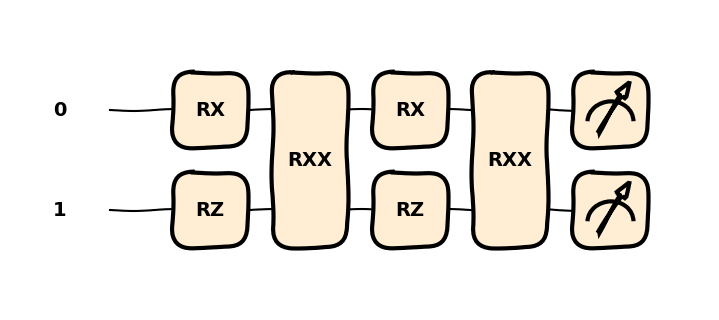

In [6]:
qml.draw_mpl(circuit, expansion_strategy='device')(t, n)
plt.show()

In [7]:
print(qml.draw(circuit, expansion_strategy='device')(t, n))

0: ──RX(1.00)─╭RXX(0.50)──RX(1.00)─╭RXX(0.50)─┤  <Z>
1: ──RZ(1.00)─╰RXX(0.50)──RZ(1.00)─╰RXX(0.50)─┤  <Z>


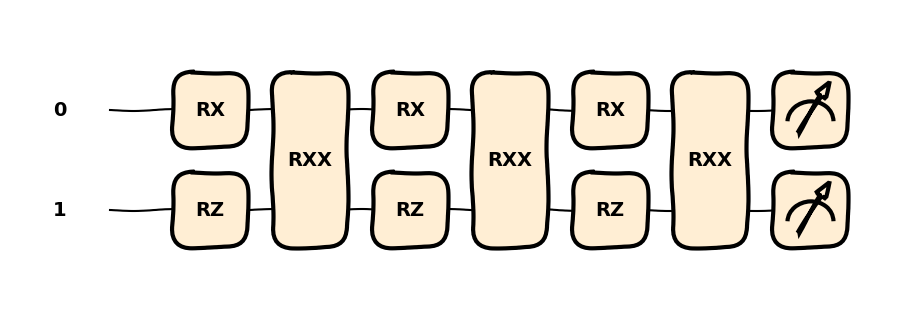

In [8]:
qml.draw_mpl(circuit, expansion_strategy='device')(t, 3)
plt.show()

In [9]:
@qml.qnode(dev)
def circuit_true(t):
    qml.evolve(H, coeff=1)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

In [10]:
print(qml.draw(circuit_true)(t))

0: ─╭Exp(-1.00j 𝓗(1.00,1.00,0.50))─┤  <Z>
1: ─╰Exp(-1.00j 𝓗(1.00,1.00,0.50))─┤  <Z>


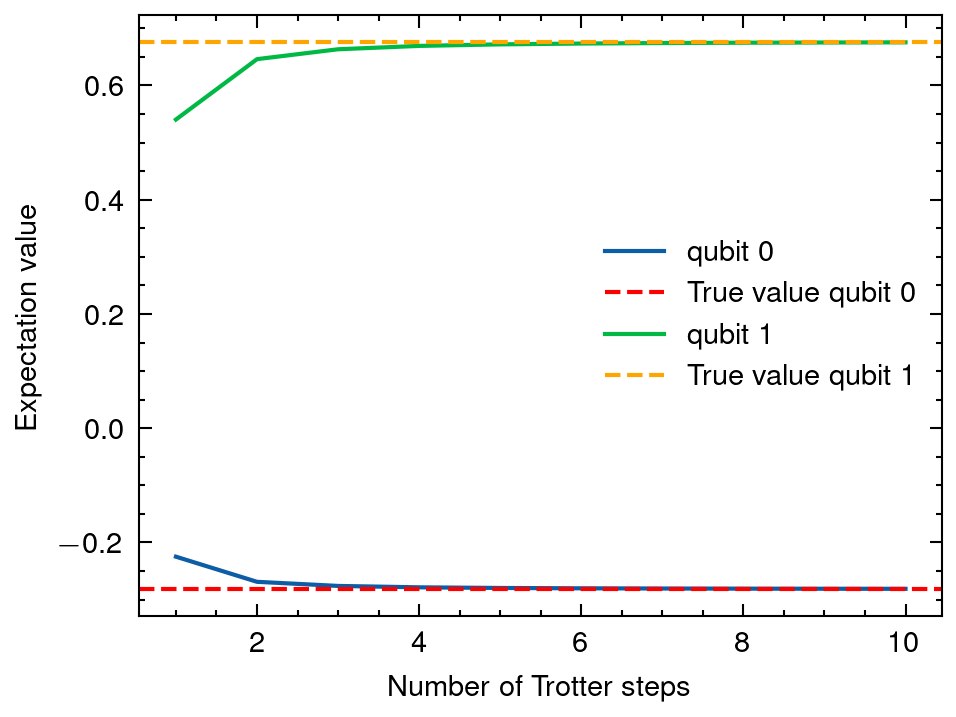

In [11]:
with plt.style.context(['science', 'nature']):
    data_0 = []
    data_1 = []
    for n in range(1, 11):
        data_0.append(circuit(t, n)[0].item())
        data_1.append(circuit(t, n)[1].item())

    true_0 = circuit_true(t)[0].item()
    true_1 = circuit_true(t)[1].item()
    
    plt.figure(dpi=300)
    plt.plot(range(1, 11), data_0, label="qubit 0")
    plt.axhline(true_0, linestyle="--", color="red", label="True value qubit 0")
    plt.plot(range(1, 11), data_1, label="qubit 1")
    plt.axhline(true_1, linestyle="--", color="orange", label="True value qubit 1")
    plt.xlabel("Number of Trotter steps")
    plt.ylabel("Expectation value")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Layering Circuits

For Quantum Neural Networks (QNNs), repeated application of a circuit is common. This is known as layering.
In pennylane, we can use the `qml.layer` function to apply a circuit multiple times.

In [12]:
def circ(theta):
    qml.RX(theta, wires=0)
    qml.Hadamard(wires=1)
    qml.CNOT(wires=[0, 1])

@qml.qnode(dev)
def circuit(theta):
    circ(theta)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

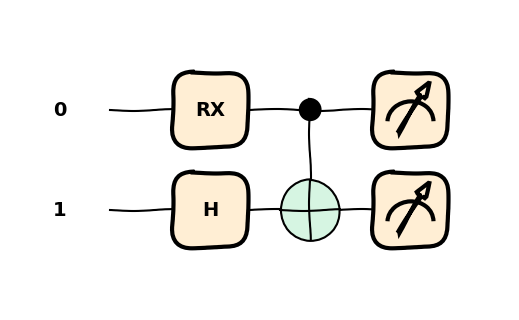

In [13]:
qml.draw_mpl(circuit)(0.5)
plt.show()

In [14]:
@qml.qnode(dev)
def circuit(params):
    qml.layer(circ, 3, params)
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

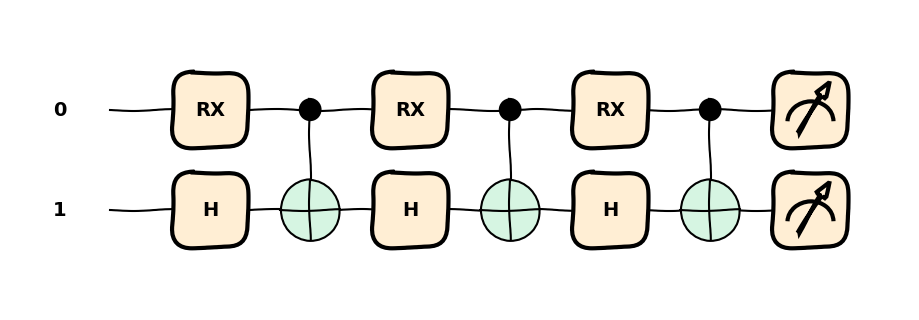

In [15]:
qml.draw_mpl(circuit)(np.array([0.1, 0.2, 0.3]))
plt.show()

## QAOA

The Quantum Approximate Optimization Algorithm (QAOA) is a well-known algorithm that can be used to find approximate solutions to combinatorial optimization problems.
The QAOA algorithm is composed of two types of unitary operators: the cost unitary operator and the mixer unitary operator. The cost unitary operator is defined as

$$
U_C(\gamma) = e^{-i\gamma H_C},
$$

where $H_C$ is the cost Hamiltonian. The mixer unitary operator is defined as

$$
U_M(\beta) = e^{-i\beta H_M},
$$

where $H_M$ is the mixer Hamiltonian.

The QAOA algorithm is composed of $p$ layers of the cost and mixer unitary operators. The QAOA circuit is given by

$$
U(\boldsymbol{\gamma}, \boldsymbol{\beta}) = U_M(\beta_p) U_C(\gamma_p) \cdots U_M(\beta_1) U_C(\gamma_1),
$$

where $\boldsymbol{\gamma} = [\gamma_1, \ldots, \gamma_p]$ and $\boldsymbol{\beta} = [\beta_1, \ldots, \beta_p]$ are the parameters of the QAOA circuit.


In this notebook, we will show how to implement a QAOA circuit to solve the minimum vertex cover problem.

In [16]:
import networkx as nx
from pennylane import qaoa

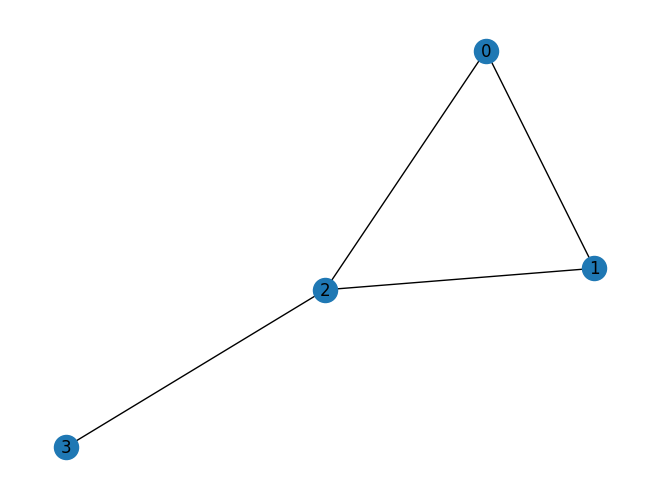

In [17]:
edges = [(0,1), (1,2), (2,0), (2,3)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)
plt.show()

In this graph, there are two minimum vertex covers: $\{0, 2\}$ and $\{1, 2\}$.
These can be represented as bitstrings $|1010\rangle$ and $|0110\rangle$, respectively.

In this case, the cost Hamiltonian has two ground states, $|1010\rangle$ and $|0110\rangle$.
The mixer Hamiltonian is just non-commuting sum of Pauli-X operations on each node of the graph.

For the MVCP, we minimize below cost functions:

$$
\begin{aligned}
F_1 &= \sum_{i=0}^{|V| - 1} x_i \quad & \text{Minimum vertex cover} \\
F_2 &= \sum_{(i, j) \in E} (1 - x_i)(1 - x_j) \quad & \text{Edge cover},
\end{aligned}
$$

where $i, j$ represent the nodes of the graph, $x_i$ is the binary variable that represents whether the node $i$ is in the vertex cover, and $E$ is the set of edges of the graph.
If we denote $S$ as the set of vertex covers, $x_i$ is 1 if $x \in S$ and 0 otherwise.

With these functions, the MVCP can be expressed as

$$
\underset{S}{\text{argmin}} \left( A F_1 + B F_2 \right),
$$

To solve the MVCP in the QAOA sense, we rewrite the variable $x_i$ as $s_i$:

$$
x_i = \frac{1 + s_i}{2}.
$$

It means that $s_i$ is 1 if $x_i = 1$ and -1 if $x_i = 0$.

Then , the cost function can be rewritten as

$$
\begin{aligned}
F &= A\sum_{i=0}^{|V| - 1} \frac{1 + s_i}{2} + B\sum_{(i, j) \in E} \left(1 - \frac{1 + s_i}{2}\right)\left(1 - \frac{1 + s_j}{2}\right) \\
&= A\sum_{i=0}^{|V| - 1} \frac{1 + s_i}{2} + B\sum_{(i, j) \in E} \left(\frac{1}{4} - \frac{s_i}{4} - \frac{s_j}{4} + \frac{s_is_j}{4}\right) \\
&= \frac{A}{2}|V| + \frac{A}{2}\sum_{i=0}^{|V|-1} s_i + \frac{B}{4}|E| - \frac{B}{4}\sum_{i=0}^{|V|-1} d_i s_i + \frac{B}{4}\sum_{(i, j) \in E} s_is_j \\
&= \frac{B}{4}\sum_{(i,j) \in E} s_i s_j + \sum_{i=0}^{|V|-1} \left(\frac{A}{2} - \frac{B}{4}d_i\right) s_i + \frac{A}{2}|V| + \frac{B}{4}|E|.
\end{aligned}
$$

where $d_i$ is the degree of the node $i$.

Finally, the cost Hamiltonian is

$$
H_C = \frac{B}{4} \sum_{(i,j) \in E} Z_i \otimes Z_j + \sum_{i=0}^{|V|-1} \left(\frac{A}{2} - \frac{B}{4}d_i\right) Z_i.
$$

In [90]:
cost_h, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian 0.75 * (Z(0) @ Z(1)) + 0.75 * Z(0) + 0.75 * Z(1) + 0.75 * (Z(0) @ Z(2)) + 0.75 * Z(0) + 0.75 * Z(2) + 0.75 * (Z(1) @ Z(2)) + 0.75 * Z(1) + 0.75 * Z(2) + 0.75 * (Z(2) @ Z(3)) + 0.75 * Z(2) + 0.75 * Z(3) + -1.0 * Z(0) + -1.0 * Z(1) + -1.0 * Z(2) + -1.0 * Z(3)
Mixer Hamiltonian 1 * X(0) + 1 * X(1) + 1 * X(2) + 1 * X(3)


$$
H_C=0.75 \sum_{(i, j) \in E}\left(Z_i \otimes Z_j\right)+0.75 \sum_{i \in V} Z_i - \sum_{i \in V}Z_i
$$

In [91]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [92]:
wires = range(4)
depth = 3

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    # qml.layer
    # params[0] = [gamma_1, gamma_2, ..., gamma_depth]
    # params[1] = [alpha_1, alpha_2, ..., alpha_depth]
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [93]:
dev = qml.device("default.qubit", wires=wires)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

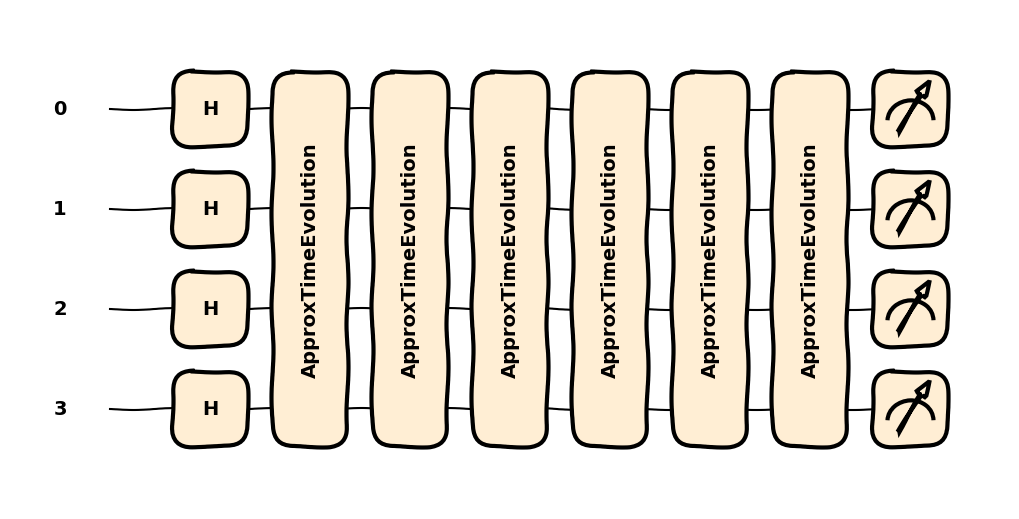

In [94]:
qml.draw_mpl(cost_function)(np.zeros((2, depth)))
plt.show()

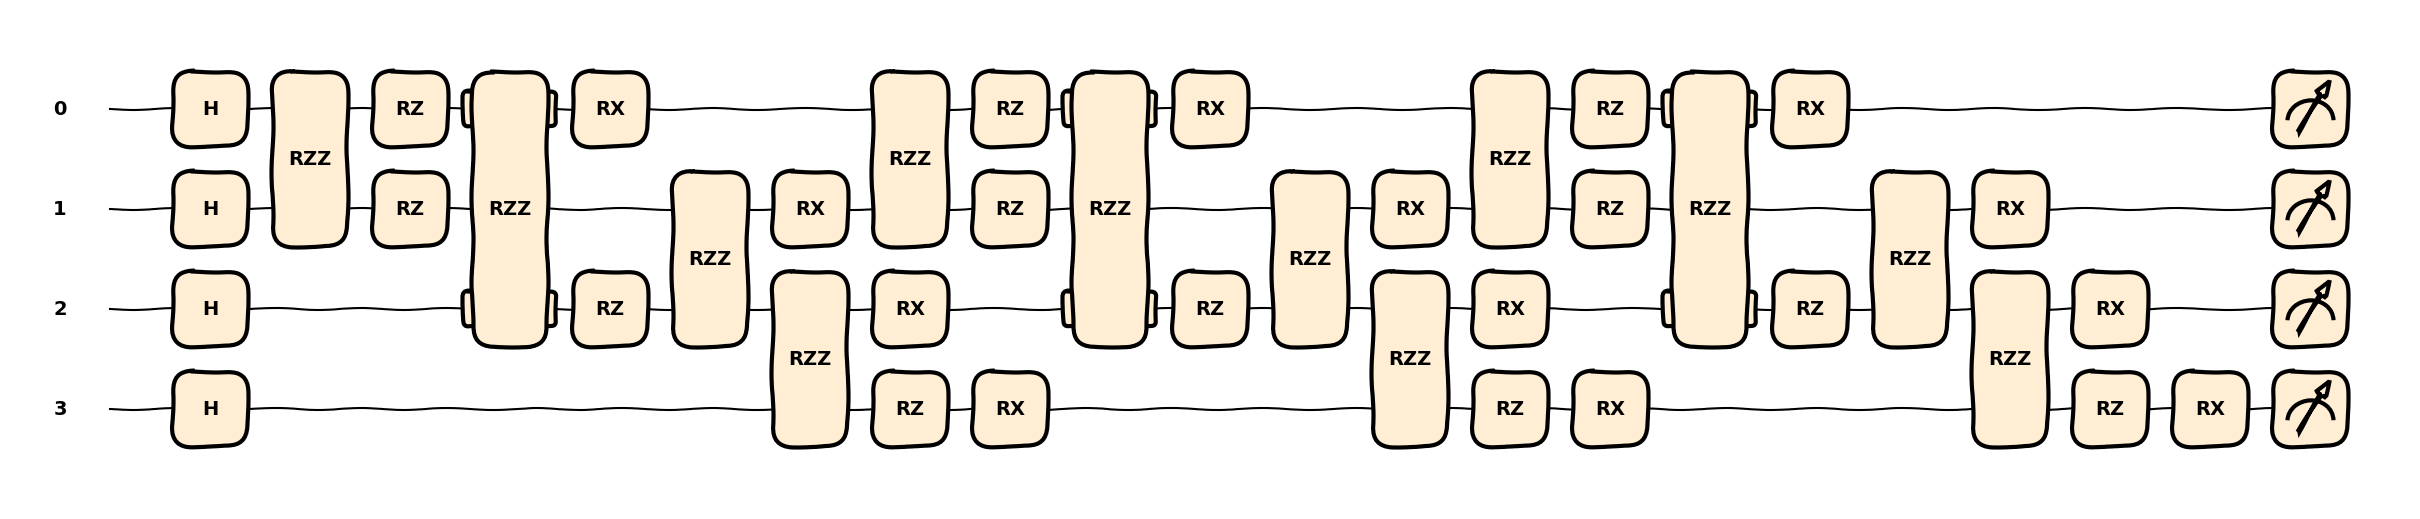

In [95]:
qml.draw_mpl(cost_function, expansion_strategy='device')(np.zeros((2, depth)))
plt.show()

In [96]:
optimizer = qml.AdamOptimizer()
steps = 200
params = np.random.uniform(size=(2, depth), requires_grad=True)

In [97]:
costs = []
for i in range(steps):
    params = optimizer.step(cost_function, params)
    cost = cost_function(params)
    costs.append(cost)
    if i % 10 == 0:
        print(f"Cost after step {i}: {cost}")

print("Optimal Parameters")
print(params)

Cost after step 0: 2.5496035030564705
Cost after step 10: 0.431142337113257
Cost after step 20: -0.22737943715221237
Cost after step 30: -0.21649578527371077
Cost after step 40: -0.3369751503352142
Cost after step 50: -0.47425245851164405
Cost after step 60: -0.604044674192973
Cost after step 70: -0.7838724498354108
Cost after step 80: -1.0235699280677302
Cost after step 90: -1.367086766901103
Cost after step 100: -1.7636072103424534
Cost after step 110: -2.1209482190925266
Cost after step 120: -2.3849450537920234
Cost after step 130: -2.4852243410576538
Cost after step 140: -2.4995615324486202
Cost after step 150: -2.496282097833414
Cost after step 160: -2.4988082873261876
Cost after step 170: -2.5005639306075835
Cost after step 180: -2.500790807996934
Cost after step 190: -2.5007730948828684
Optimal Parameters
[[-0.3403807  -0.47174633  0.82605569]
 [ 0.73280223  0.35100523 -0.31683459]]


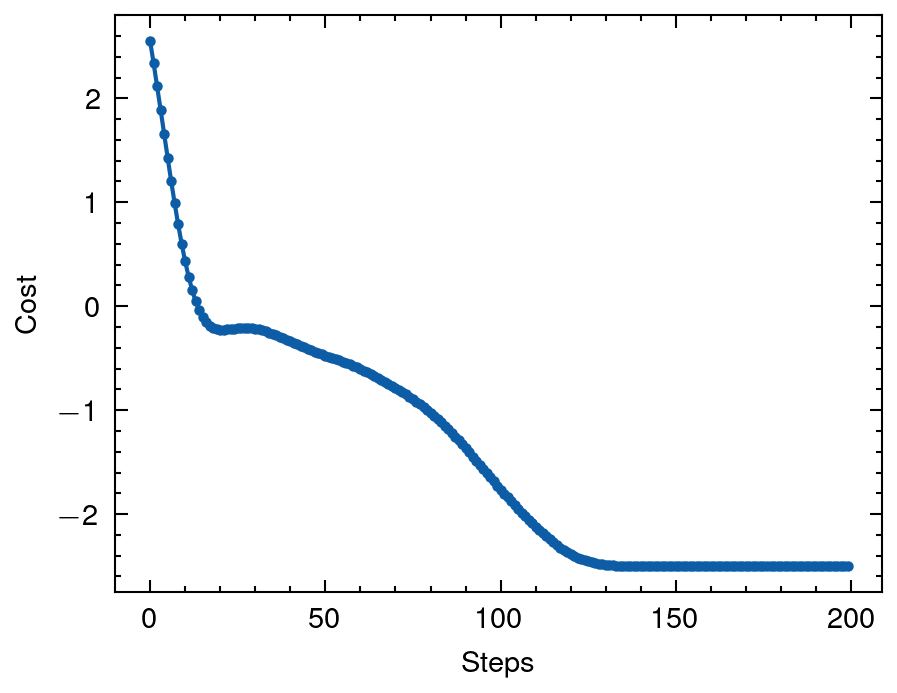

In [98]:
with plt.style.context(['science', 'nature']):
    plt.figure(dpi=300)
    plt.plot(costs, marker=".")
    plt.xlabel("Steps")
    plt.ylabel("Cost")
    plt.show()

In [99]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

In [100]:
probs = probability_circuit(params[0], params[1])

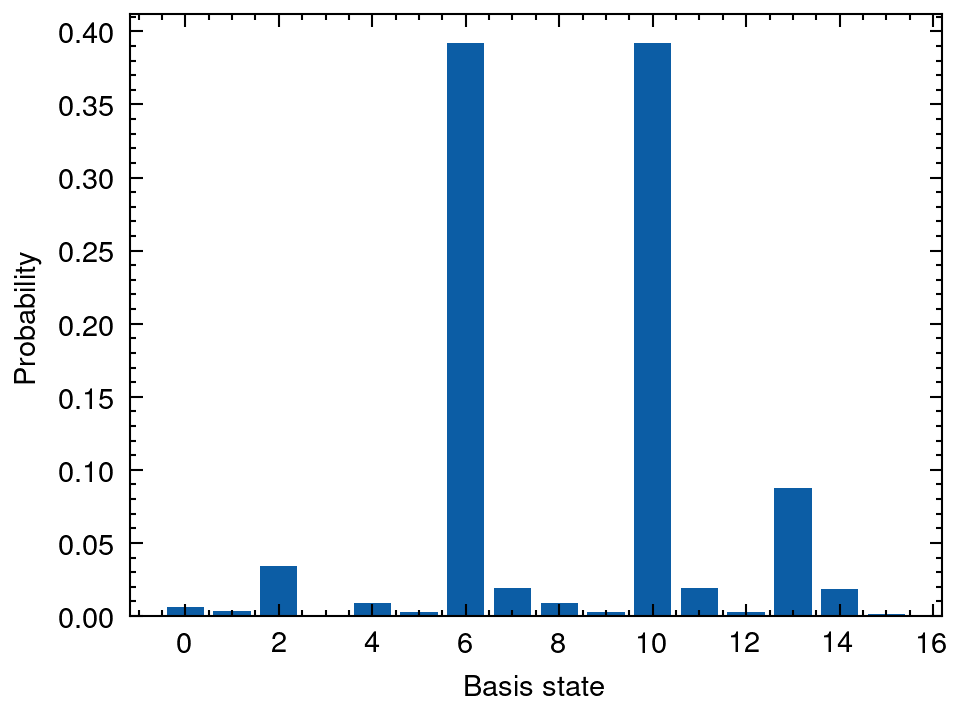

In [101]:
with plt.style.context(['science', 'nature']):
    plt.figure(dpi=300)
    plt.bar(range(2**len(wires)), probs)
    plt.xlabel("Basis state")
    plt.ylabel("Probability")
    plt.tight_layout()
    plt.show()

Therefore, the states $|6\rangle = |0110\rangle$ and $|10\rangle = |1010\rangle$ are the ground states of the cost Hamiltonian.

## Custom Hamiltonian

Recall that the cost Hamiltonian is given by

$$
H_C = \frac{B}{4} \sum_{(i,j) \in E} Z_i \otimes Z_j + \sum_{i=0}^{|V|-1} \left(\frac{A}{2} - \frac{B}{4}d_i\right) Z_i.
$$

Now let's try to implement this Hamiltonian in pennylane by hand.

- $A = 2$
- $B = 4$

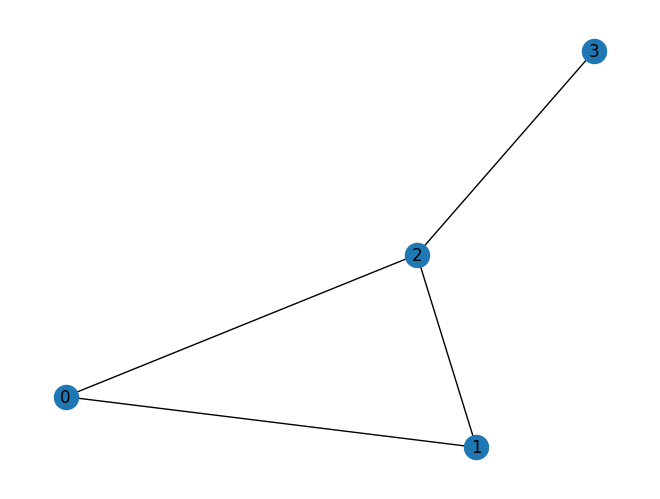

In [30]:
edges = [(0,1), (1,2), (2,0), (2,3)]
graph = nx.Graph(edges)

nx.draw(graph, with_labels=True)
plt.show()

In [102]:
A = 1
B = 1

In [103]:
cost_h_1 = qml.Hamiltonian(
    [B/4, B/4, B/4, B/4],
    [qml.PauliZ(0) @ qml.PauliZ(1), qml.PauliZ(0) @ qml.PauliZ(2), qml.PauliZ(1) @ qml.PauliZ(2), qml.PauliZ(2) @ qml.PauliZ(3)]
)
cost_h_1

(
    0.25 * (Z(0) @ Z(1))
  + 0.25 * (Z(0) @ Z(2))
  + 0.25 * (Z(1) @ Z(2))
  + 0.25 * (Z(2) @ Z(3))
)

In [104]:
cost_h_2 = qml.Hamiltonian(
    [A/2, A/2, A/2, A/2],
    [qml.PauliZ(0), qml.PauliZ(1), qml.PauliZ(2), qml.PauliZ(3)]    
)
cost_h_2

0.5 * Z(0) + 0.5 * Z(1) + 0.5 * Z(2) + 0.5 * Z(3)

In [116]:
d = np.array([2, 2, 1, 3])
b = -np.array([B/4, B/4, B/4, B/4])
coef = d * b

cost_h_3 = qml.Hamiltonian(
    coef,
    [qml.PauliZ(0), qml.PauliZ(1), qml.PauliZ(2), qml.PauliZ(3)]
)
cost_h_3

(
    -0.5 * Z(0)
  + -0.5 * Z(1)
  + -0.25 * Z(2)
  + -0.75 * Z(3)
)

In [117]:
cost_h = cost_h_1 + cost_h_2 + cost_h_3
cost_h

(
    0.25 * (Z(0) @ Z(1))
  + 0.25 * (Z(0) @ Z(2))
  + 0.25 * (Z(1) @ Z(2))
  + 0.25 * (Z(2) @ Z(3))
  + 0.5 * Z(0)
  + 0.5 * Z(1)
  + 0.5 * Z(2)
  + 0.5 * Z(3)
  + -0.5 * Z(0)
  + -0.5 * Z(1)
  + -0.25 * Z(2)
  + -0.75 * Z(3)
)

In [118]:
_, mixer_h = qaoa.min_vertex_cover(graph, constrained=False)

print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian 0.25 * (Z(0) @ Z(1)) + 0.25 * (Z(0) @ Z(2)) + 0.25 * (Z(1) @ Z(2)) + 0.25 * (Z(2) @ Z(3)) + 0.5 * Z(0) + 0.5 * Z(1) + 0.5 * Z(2) + 0.5 * Z(3) + -0.5 * Z(0) + -0.5 * Z(1) + -0.25 * Z(2) + -0.75 * Z(3)
Mixer Hamiltonian 1 * X(0) + 1 * X(1) + 1 * X(2) + 1 * X(3)


In [119]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [120]:
wires = range(4)
depth = 3

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    # qml.layer
    # params[0] = [gamma_1, gamma_2, ..., gamma_depth]
    # params[1] = [alpha_1, alpha_2, ..., alpha_depth]
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [121]:
dev = qml.device("default.qubit", wires=wires)

@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

In [122]:
optimizer = qml.AdamOptimizer()
steps = 200
params = np.random.uniform(size=(2, depth), requires_grad=True)

In [123]:
costs = []
min_cost = 10
early_stopping_count = 0
for i in range(steps):
    params = optimizer.step(cost_function, params)
    cost = cost_function(params)
    costs.append(cost)
    if i % 10 == 0:
        print(f"Cost after step {i}: {cost}")
    if cost < min_cost:
        min_cost = cost
        early_stopping_count = 0
    else:
        early_stopping_count += 1
    if early_stopping_count == 10:
        print("Early stopping")
        break

print("Optimal Parameters")
print(params)

Cost after step 0: 0.003217789211519051
Cost after step 10: -0.1118672200381835
Cost after step 20: -0.16998460480331673
Cost after step 30: -0.20040230094962758
Cost after step 40: -0.21973484874903504
Cost after step 50: -0.23358037017035194
Cost after step 60: -0.24538957602262057
Cost after step 70: -0.257853906457208
Cost after step 80: -0.2734951192671741
Cost after step 90: -0.2955927853031287
Cost after step 100: -0.3309105965427506
Cost after step 110: -0.400719551377899
Cost after step 120: -0.536686886292598
Cost after step 130: -0.6747203266020942
Cost after step 140: -0.7846476301698221
Cost after step 150: -0.8435837460694816
Cost after step 160: -0.8737336667815854
Cost after step 170: -0.8886732029964415
Cost after step 180: -0.8968776050714049
Cost after step 190: -0.902854324108875
Optimal Parameters
[[ 1.16053703 -0.7942621   1.32913743]
 [ 1.49974159  0.96753716 -0.3660007 ]]


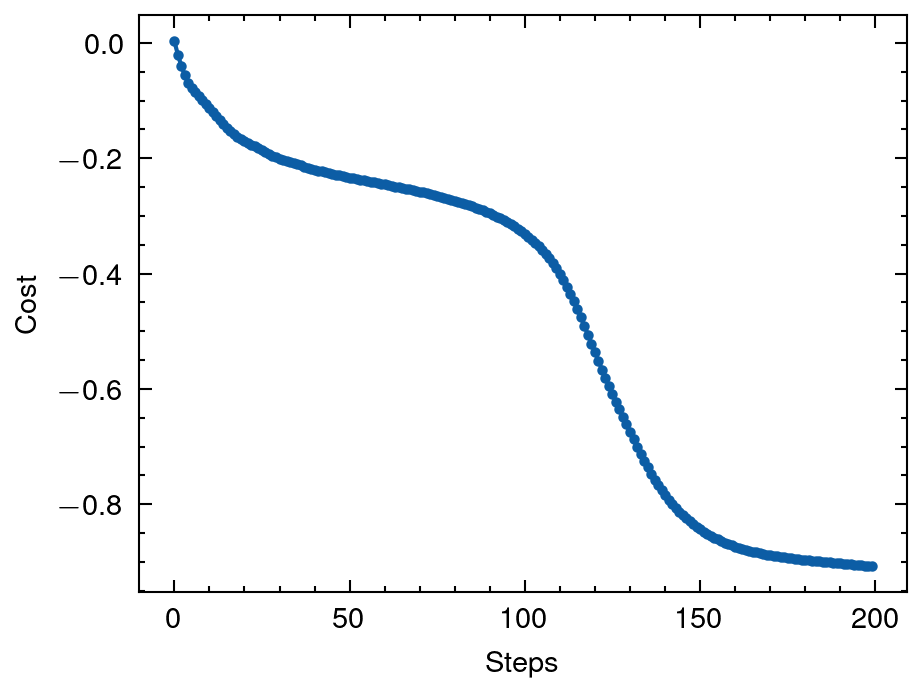

In [124]:
with plt.style.context(['science', 'nature']):
    plt.figure(dpi=300)
    plt.plot(costs, marker=".")
    plt.xlabel("Steps")
    plt.ylabel("Cost")
    plt.show()

In [125]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

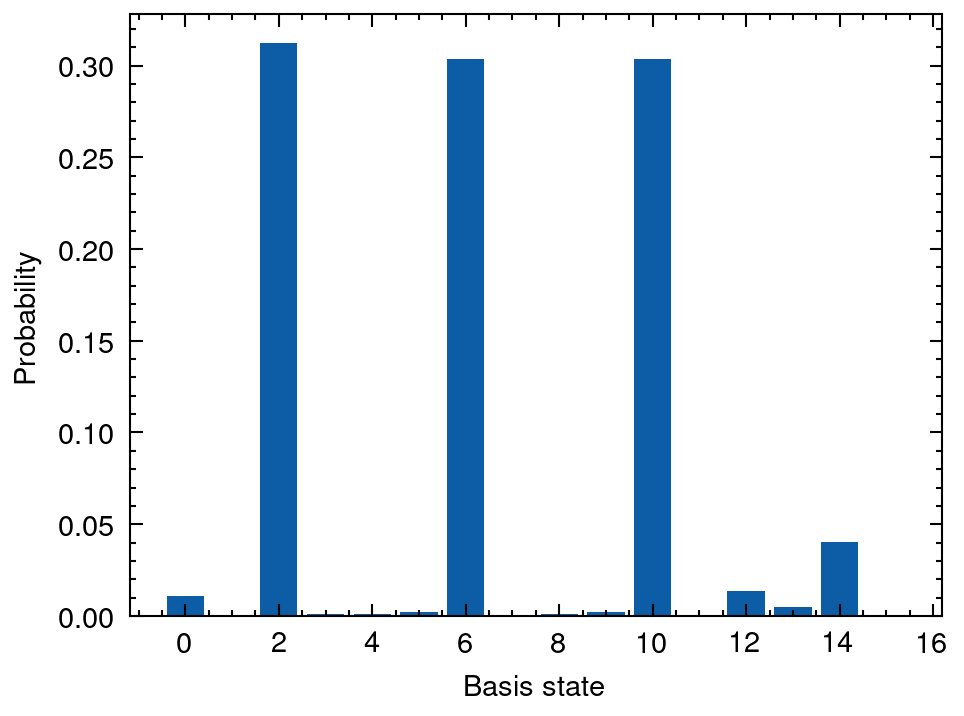

In [126]:
probs = probability_circuit(params[0], params[1])

with plt.style.context(['science', 'nature']):
    plt.figure(dpi=300)
    plt.bar(range(2**len(wires)), probs)
    plt.xlabel("Basis state")
    plt.ylabel("Probability")
    plt.tight_layout()
    plt.show()

The ground states are $|6\rangle = |0101\rangle$ and $|10\rangle = |1001\rangle$.